In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [ ]:
num_samples = 100
sample_range = range(0, 100)

Sparse Bayesian Learning (SBL)

In [ ]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.5, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [ ]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.09s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.62s/it]

Converged after 425 outer iterations



Processing Samples:   1%|          | 1/100 [01:45<2:53:15, 105.00s/it]

Converged after 320 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:56<00:58, 19.34s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.60s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.42s/it]

Converged after 459 outer iterations



Processing Samples:   2%|▏         | 2/100 [03:32<2:53:36, 106.30s/it]

Converged after 355 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.45s/it]

Converged after 347 outer iterations



Processing Samples:   3%|▎         | 3/100 [05:17<2:50:50, 105.68s/it]

Converged after 339 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:41<01:22, 20.57s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:17<00:37, 18.71s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:17, 17.85s/it]

Converged after 392 outer iterations



Processing Samples:   4%|▍         | 4/100 [07:03<2:49:46, 106.11s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:38, 19.02s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.82s/it]

Converged after 369 outer iterations



Processing Samples:   5%|▌         | 5/100 [08:56<2:51:54, 108.57s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.49s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.88s/it]

Converged after 458 outer iterations



Processing Samples:   6%|▌         | 6/100 [10:47<2:51:20, 109.36s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.92s/it]

Converged after 447 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.25s/it]

Converged after 343 outer iterations



Processing Samples:   7%|▋         | 7/100 [12:32<2:47:17, 107.93s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.03s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.51s/it]

Converged after 418 outer iterations



Processing Samples:   8%|▊         | 8/100 [14:17<2:44:11, 107.08s/it]

Converged after 347 outer iterations



Processing Samples:   9%|▉         | 9/100 [16:14<2:46:51, 110.02s/it]

Converged after 322 outer iterations



Processing Samples:  10%|█         | 10/100 [18:02<2:44:02, 109.36s/it]

Converged after 283 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.62s/it]

Converged after 484 outer iterations



Processing Samples:  11%|█         | 11/100 [19:54<2:43:17, 110.09s/it]

Converged after 389 outer iterations



Processing Samples:  12%|█▏        | 12/100 [21:43<2:41:15, 109.95s/it]

Converged after 322 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.18s/it]

Converged after 361 outer iterations



Processing Samples:  13%|█▎        | 13/100 [23:26<2:36:04, 107.64s/it]

Converged after 314 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:53, 17.82s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.90s/it]

Converged after 457 outer iterations



Processing Samples:  14%|█▍        | 14/100 [25:11<2:33:12, 106.89s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.07s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.53s/it]

Converged after 339 outer iterations



Processing Samples:  15%|█▌        | 15/100 [26:54<2:30:04, 105.94s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.35s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.52s/it]

Converged after 453 outer iterations



Processing Samples:  16%|█▌        | 16/100 [28:42<2:29:04, 106.49s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.09s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.86s/it]

Converged after 300 outer iterations



Processing Samples:  17%|█▋        | 17/100 [30:14<2:21:04, 101.98s/it]

Converged after 292 outer iterations



Processing Samples:  18%|█▊        | 18/100 [32:08<2:24:19, 105.60s/it]

Converged after 352 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:38, 19.06s/it]

Converged after 496 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.12s/it]

Converged after 336 outer iterations



Processing Samples:  19%|█▉        | 19/100 [33:52<2:21:53, 105.10s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.86s/it]

Converged after 328 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.16s/it]

Converged after 333 outer iterations



Processing Samples:  20%|██        | 20/100 [35:32<2:18:04, 103.55s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.94s/it]

Converged after 425 outer iterations



Processing Samples:  21%|██        | 21/100 [37:21<2:18:42, 105.35s/it]

Converged after 327 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.75s/it]

Converged after 357 outer iterations



Processing Samples:  22%|██▏       | 22/100 [39:08<2:17:38, 105.88s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.18s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.72s/it]

Converged after 370 outer iterations
Converged after 403 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.05s/it]

Converged after 359 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:15, 15.96s/it]

Converged after 348 outer iterations



Processing Samples:  24%|██▍       | 24/100 [42:36<2:13:17, 105.23s/it]

Converged after 478 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.00s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.04s/it]

Converged after 312 outer iterations



Processing Samples:  25%|██▌       | 25/100 [44:16<2:09:25, 103.54s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.74s/it]

Converged after 357 outer iterations



Processing Samples:  26%|██▌       | 26/100 [46:01<2:08:22, 104.09s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.56s/it]

Converged after 337 outer iterations



Processing Samples:  27%|██▋       | 27/100 [47:48<2:07:46, 105.02s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.23s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.99s/it]

Converged after 460 outer iterations



Processing Samples:  28%|██▊       | 28/100 [49:33<2:05:48, 104.83s/it]

Converged after 340 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.54s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.78s/it]

Converged after 389 outer iterations



Processing Samples:  29%|██▉       | 29/100 [51:15<2:03:06, 104.04s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:57<00:57, 19.19s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.36s/it]

Converged after 371 outer iterations



Processing Samples:  30%|███       | 30/100 [53:03<2:02:55, 105.36s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.41s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.15s/it]

Converged after 404 outer iterations



Processing Samples:  31%|███       | 31/100 [54:49<2:01:07, 105.32s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.81s/it]

Converged after 394 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.93s/it]

Converged after 424 outer iterations
Converged after 339 outer iterations



Processing Samples:  32%|███▏      | 32/100 [56:28<1:57:14, 103.44s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:18<00:39, 19.66s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.02s/it]

Converged after 460 outer iterations



Processing Samples:  33%|███▎      | 33/100 [58:19<1:58:04, 105.73s/it]

Converged after 346 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.11s/it]

Converged after 418 outer iterations



Processing Samples:  34%|███▍      | 34/100 [1:00:07<1:57:16, 106.62s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.49s/it]

Converged after 353 outer iterations



Processing Samples:  35%|███▌      | 35/100 [1:01:52<1:54:53, 106.05s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.52s/it]

Converged after 367 outer iterations



Processing Samples:  36%|███▌      | 36/100 [1:03:37<1:52:52, 105.82s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.43s/it]

Converged after 339 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.28s/it]

Converged after 407 outer iterations



Processing Samples:  37%|███▋      | 37/100 [1:05:17<1:49:01, 103.83s/it]

Converged after 312 outer iterations



Processing Samples:  38%|███▊      | 38/100 [1:07:07<1:49:17, 105.76s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:02<01:01, 20.51s/it]

Converged after 492 outer iterations



Processing Samples:  39%|███▉      | 39/100 [1:09:10<1:52:41, 110.84s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.47s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.85s/it]

Converged after 340 outer iterations



Processing Samples:  40%|████      | 40/100 [1:10:51<1:47:56, 107.94s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:38, 19.14s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.03s/it]

Converged after 407 outer iterations



Processing Samples:  41%|████      | 41/100 [1:12:43<1:47:17, 109.11s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.40s/it]

Converged after 492 outer iterations



Processing Samples:  42%|████▏     | 42/100 [1:14:36<1:46:48, 110.50s/it]

Converged after 413 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:36<01:13, 18.30s/it]

Converged after 447 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.47s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.24s/it]

Converged after 343 outer iterations



Processing Samples:  43%|████▎     | 43/100 [1:16:16<1:41:52, 107.24s/it]

Converged after 340 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.72s/it]

Converged after 392 outer iterations



Processing Samples:  44%|████▍     | 44/100 [1:18:04<1:40:17, 107.45s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.16s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.48s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.60s/it]

Converged after 375 outer iterations



Processing Samples:  46%|████▌     | 46/100 [1:21:42<1:37:06, 107.90s/it]

Converged after 408 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:19<00:40, 20.39s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.10s/it]

Converged after 433 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:23:35<1:36:36, 109.37s/it]

Converged after 385 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.92s/it]

Converged after 373 outer iterations



Processing Samples:  48%|████▊     | 48/100 [1:25:23<1:34:18, 108.82s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.13s/it]

Converged after 386 outer iterations



Processing Samples:  49%|████▉     | 49/100 [1:27:10<1:31:58, 108.21s/it]

Converged after 328 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.56s/it]

Converged after 417 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:28:58<1:30:13, 108.27s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:52, 17.56s/it]

Converged after 415 outer iterations



Processing Samples:  51%|█████     | 51/100 [1:30:49<1:29:00, 108.99s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.30s/it]

Converged after 396 outer iterations



Processing Samples:  52%|█████▏    | 52/100 [1:32:34<1:26:15, 107.82s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:58<00:58, 19.54s/it]

Converged after 469 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:35, 17.94s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.72s/it]

Converged after 358 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:34:15<1:23:01, 105.98s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.58s/it]

Converged after 439 outer iterations



Processing Samples:  54%|█████▍    | 54/100 [1:36:04<1:21:50, 106.75s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:53, 17.93s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.76s/it]

Converged after 371 outer iterations



Processing Samples:  55%|█████▌    | 55/100 [1:37:56<1:21:11, 108.25s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:35, 17.78s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:16, 16.94s/it]

Converged after 384 outer iterations



Processing Samples:  56%|█████▌    | 56/100 [1:39:43<1:19:13, 108.03s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.22s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.04s/it]

Converged after 334 outer iterations



Processing Samples:  57%|█████▋    | 57/100 [1:41:25<1:15:59, 106.03s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.20s/it]

Converged after 445 outer iterations



Processing Samples:  58%|█████▊    | 58/100 [1:43:17<1:15:32, 107.92s/it]

Converged after 355 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:52, 17.38s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.31s/it]

Converged after 420 outer iterations



Processing Samples:  59%|█████▉    | 59/100 [1:45:06<1:13:53, 108.15s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.78s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.39s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.11s/it]

Converged after 364 outer iterations



Processing Samples:  61%|██████    | 61/100 [1:48:44<1:10:26, 108.36s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.08s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.66s/it]

Converged after 489 outer iterations



Processing Samples:  62%|██████▏   | 62/100 [1:50:29<1:07:54, 107.23s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:17, 17.98s/it]

Converged after 363 outer iterations
Converged after 297 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.66s/it]

Converged after 401 outer iterations



Processing Samples:  64%|██████▍   | 64/100 [1:54:03<1:04:29, 107.47s/it]

Converged after 261 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [1:55:50<1:02:36, 107.33s/it]

Converged after 275 outer iterations



Processing Samples:  66%|██████▌   | 66/100 [1:57:44<1:01:57, 109.33s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.58s/it]

Converged after 407 outer iterations



Processing Samples:  67%|██████▋   | 67/100 [1:59:37<1:00:44, 110.43s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:38, 19.18s/it]

Converged after 489 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.11s/it]

Converged after 414 outer iterations



Processing Samples:  68%|██████▊   | 68/100 [2:01:25<58:25, 109.54s/it]  

Converged after 412 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.51s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.99s/it]

Converged after 448 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [2:03:07<55:32, 107.49s/it]

Converged after 238 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:58<00:56, 18.67s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:34, 17.50s/it]

Converged after 408 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.19s/it]

Converged after 427 outer iterations



Processing Samples:  70%|███████   | 70/100 [2:04:53<53:27, 106.93s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:34, 17.48s/it]

Converged after 404 outer iterations



Processing Samples:  71%|███████   | 71/100 [2:06:39<51:34, 106.72s/it]

Converged after 260 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:38, 19.08s/it]

Converged after 489 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.17s/it]

Converged after 413 outer iterations



Processing Samples:  72%|███████▏  | 72/100 [2:08:25<49:39, 106.42s/it]

Converged after 352 outer iterations



Processing Samples:  73%|███████▎  | 73/100 [2:10:19<48:52, 108.60s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.28s/it]

Converged after 417 outer iterations



Processing Samples:  74%|███████▍  | 74/100 [2:12:07<47:06, 108.71s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:17<00:39, 19.51s/it]

Converged after 495 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:40<00:20, 20.81s/it]

Converged after 444 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:50, 16.92s/it]

Converged after 409 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.59s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.22s/it]

Converged after 361 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [2:15:42<42:45, 106.90s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.69s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.94s/it]

Converged after 432 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [2:17:26<40:38, 106.03s/it]

Converged after 315 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.21s/it]

Converged after 375 outer iterations



Processing Samples:  78%|███████▊  | 78/100 [2:19:13<39:01, 106.44s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.12s/it]

Converged after 363 outer iterations



Processing Samples:  79%|███████▉  | 79/100 [2:21:01<37:20, 106.70s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.89s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.92s/it]

Converged after 355 outer iterations



Processing Samples:  80%|████████  | 80/100 [2:22:41<34:54, 104.73s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.26s/it]

Converged after 428 outer iterations



Processing Samples:  81%|████████  | 81/100 [2:24:34<33:57, 107.24s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.69s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.45s/it]

Converged after 385 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:26:17<31:45, 105.87s/it]

Converged after 285 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:54, 18.22s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.80s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.01s/it]

Converged after 390 outer iterations



Processing Samples:  83%|████████▎ | 83/100 [2:28:01<29:50, 105.33s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:18, 18.97s/it]

Converged after 430 outer iterations



Processing Samples:  84%|████████▍ | 84/100 [2:29:52<28:35, 107.25s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.20s/it]

Converged after 446 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [2:31:37<26:34, 106.30s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:54, 18.14s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.44s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.43s/it]

Converged after 365 outer iterations



Processing Samples:  86%|████████▌ | 86/100 [2:33:19<24:30, 105.03s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.34s/it]

Converged after 346 outer iterations



Processing Samples:  87%|████████▋ | 87/100 [2:35:04<22:48, 105.26s/it]

Converged after 359 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.09s/it]

Converged after 420 outer iterations



Processing Samples:  88%|████████▊ | 88/100 [2:36:50<21:02, 105.21s/it]

Converged after 337 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:38, 19.37s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.86s/it]

Converged after 366 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [2:38:40<19:34, 106.76s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:41<01:22, 20.71s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:57<00:55, 18.51s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.35s/it]

Converged after 382 outer iterations



Processing Samples:  90%|█████████ | 90/100 [2:40:25<17:44, 106.40s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.95s/it]

Converged after 376 outer iterations



Processing Samples:  91%|█████████ | 91/100 [2:42:16<16:07, 107.49s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.26s/it]

Converged after 335 outer iterations



Processing Samples:  92%|█████████▏| 92/100 [2:44:02<14:16, 107.04s/it]

Converged after 348 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [2:45:50<12:31, 107.33s/it]

Converged after 329 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.05s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.70s/it]

Converged after 450 outer iterations



Processing Samples:  94%|█████████▍| 94/100 [2:47:36<10:43, 107.17s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:39, 19.85s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.45s/it]

Converged after 468 outer iterations



Processing Samples:  95%|█████████▌| 95/100 [2:49:33<09:10, 110.07s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.30s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.99s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:14, 15.00s/it]

Converged after 303 outer iterations



Processing Samples:  96%|█████████▌| 96/100 [2:51:07<07:00, 105.19s/it]

Converged after 304 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.02s/it]

Converged after 377 outer iterations



Processing Samples:  97%|█████████▋| 97/100 [2:52:55<05:18, 106.08s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:39, 19.68s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.17s/it]

Converged after 394 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [2:54:44<03:33, 106.83s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.70s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.42s/it]

Converged after 438 outer iterations



Processing Samples:  99%|█████████▉| 99/100 [2:56:28<01:46, 106.14s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 18.00s/it]

Converged after 384 outer iterations



Processing Samples: 100%|██████████| 100/100 [2:58:12<00:00, 106.93s/it]

Converged after 329 outer iterations


In [ ]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [63.2  86.65 97.45 99.45 99.8  99.75]
Avg SRR : [0.3582053  0.60593559 0.8104023  0.90393181 0.94287201 0.96503223]
Avg FR  : [3.16052632 2.08421053 1.01842105 0.53421053 0.31052632 0.17631579]
Avg PR  : [0.51963298 0.6975914  0.84078626 0.91200261 0.94642716 0.96938396]
Avg RE  : [0.632  0.8665 0.9745 0.9945 0.998  0.9975]
Avg F1  : [0.56944393 0.77114835 0.90107946 0.950307   0.97093107 0.98276258]
Avg NMSE: [0.60053741 0.34200461 0.15167352 0.09149334 0.06393397 0.05034894]


In [ ]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-100-casbl-anc-alpha-1-50-beta-0-10-snr-db-12-pilot-length-all.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


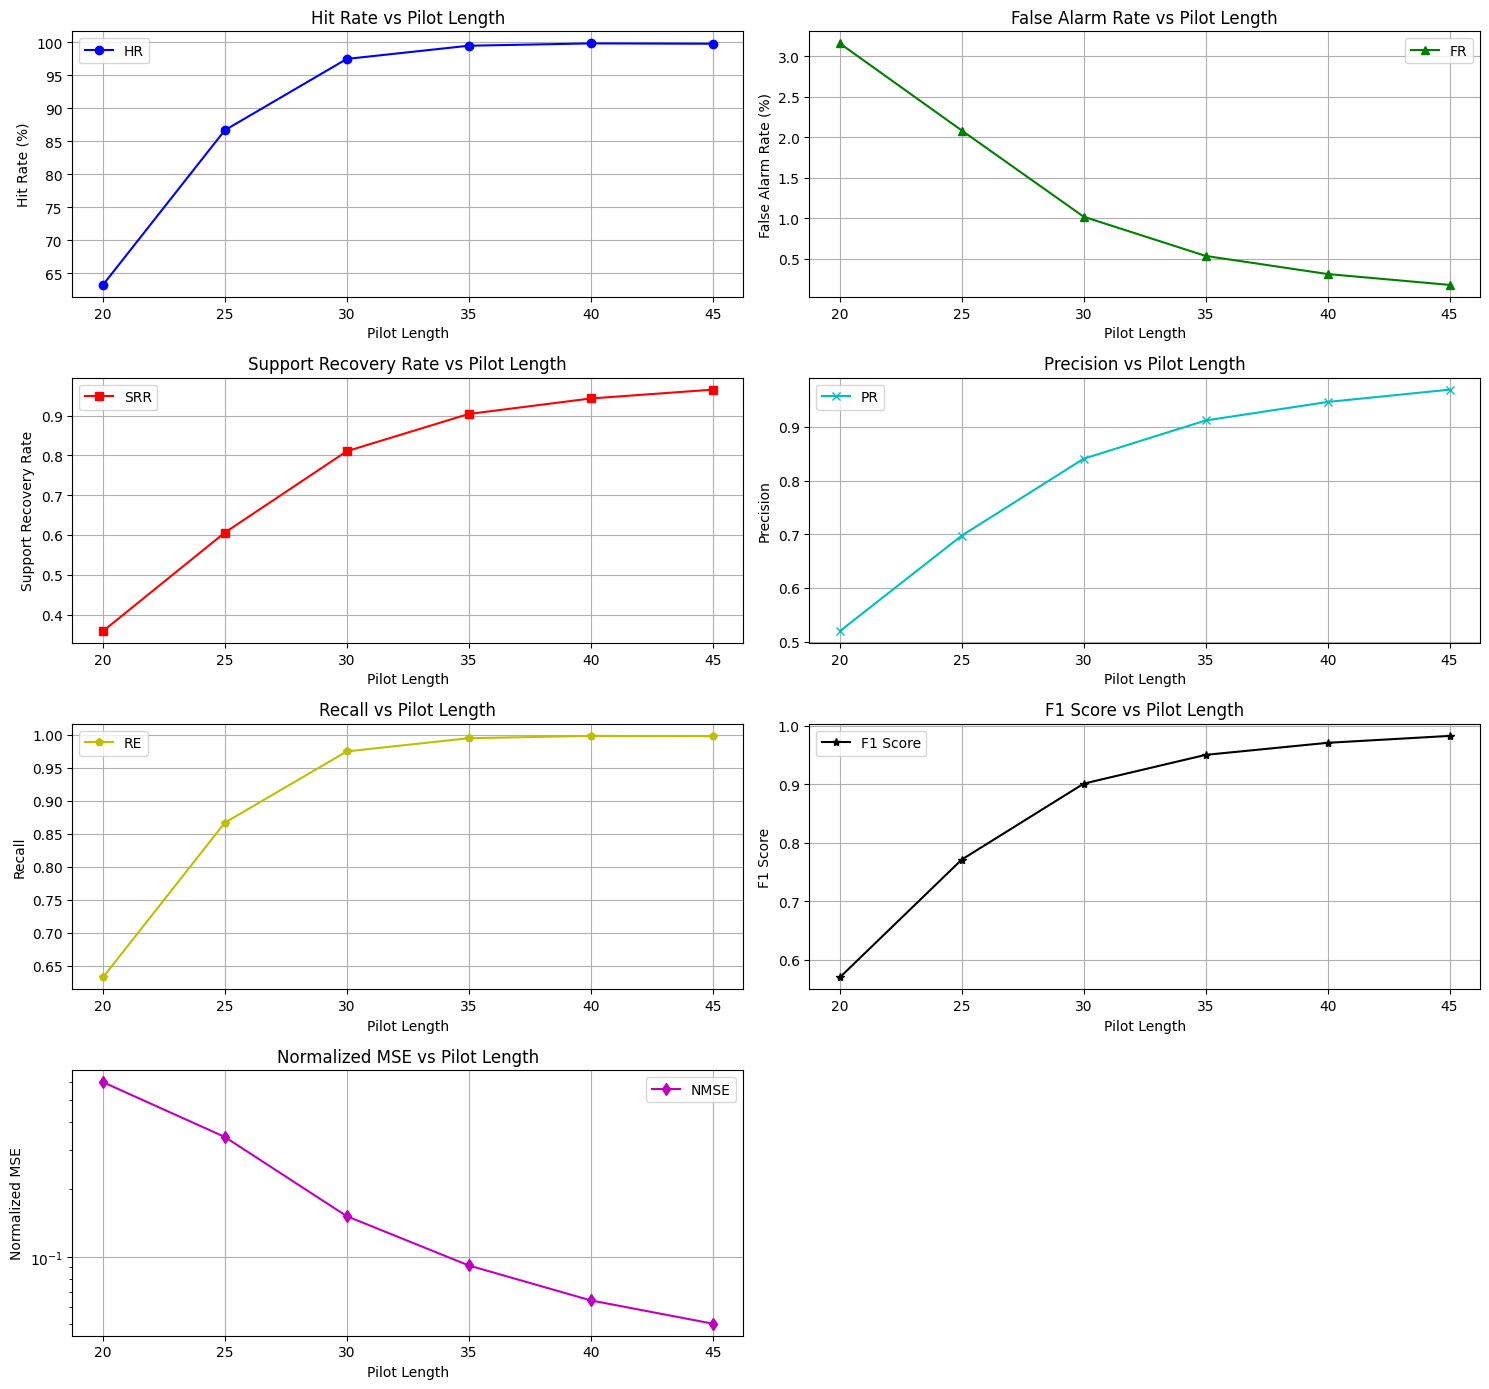

In [ ]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

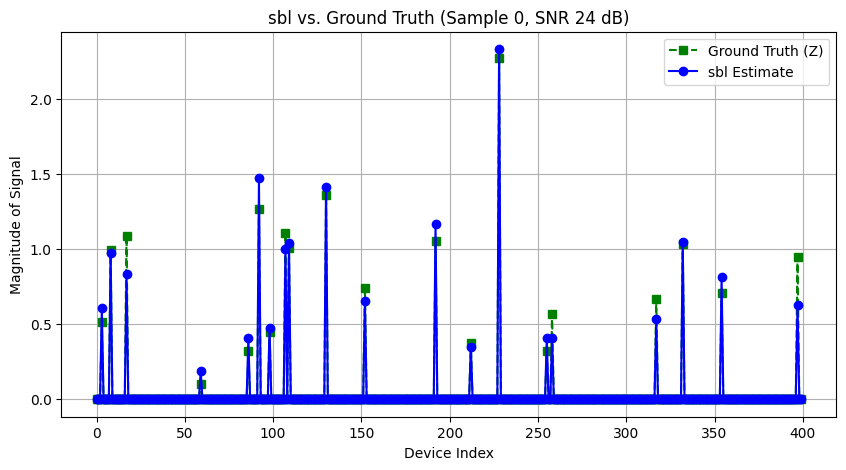

In [ ]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


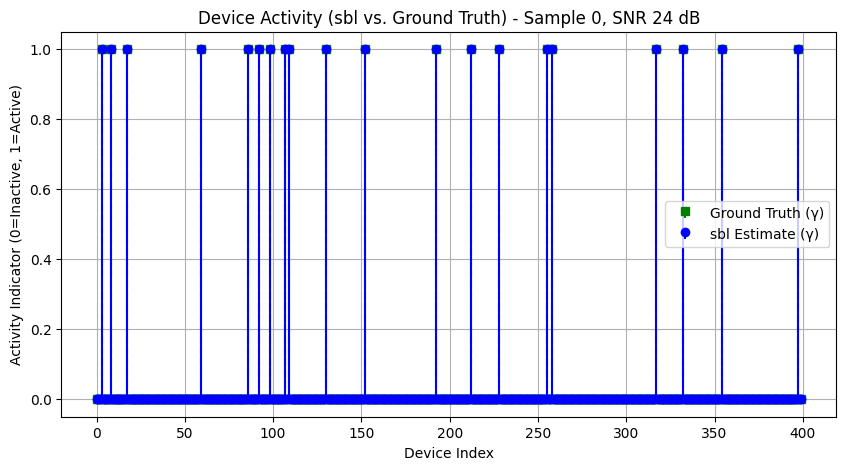

In [ ]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)